In [26]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import pickle

import swimAD2 as ad2       # copy swimAD2.py to your working directory
import time

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

We start by assuming that the two resistances were given. We also take the time interval of the measurement as a fixed given. 

Have a list of input voltages. For each input voltage, measure the voltages on scope 1 and scope 2 from start to finish of the measurement range. Here, mind the time steps of measurements.



In [44]:
# Set the measurement parameters. 

def prepare_measurement(inpt,hertz,points):
    ad2.config_wavegen(
        zoroku,                                    # name of device
        frequency=0.2,                           # max 10 MHz
        amplitude=inpt,                              # max 5 V
        signal_shape=ad2.dwfc.funcSine ,         # output signal shape: funcSine, funcSquare, funcTriangle, funcRampUp, funcRampDown, funcNoise
        offset=1,                               # signal voltage offset
        # phase=0,                                # signal phase
        # symmetry=50,                            # signal symmetry shape
        # channel=0                               # channel 0 / 1 (or -1 for all channels)
    )
    
    ad2.config_oscilloscope(
        zoroku,                        # name of device
        range0=.25,                     # Oscilloscope Channel 0 voltage range, max 25 V
        range1=.25,                     # Oscilloscope Channel 2
        sample_rate=hertz,           # max 100 MHz
        sample_size=points,           # max 8192, sample time = sample_size / sample_rate
        )

OverflowError
Sample time: 0.08192
Sample size is: 8192


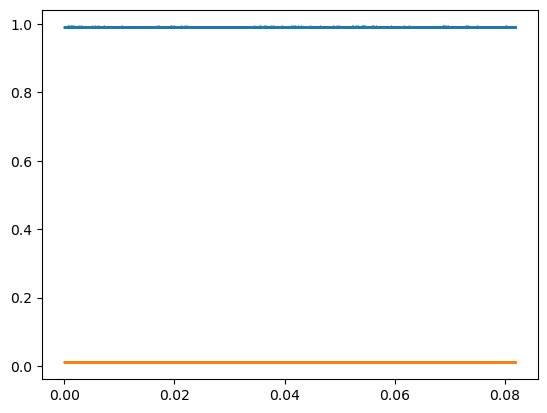

In [50]:
hertz=100e3 # Frequency of detections by Zoroku in Hz, max 100MHz.
samp_time = 1 # Duration of our measurement in s. 

R1 = 10 # Resistance in Ohms. 
R2 = 1000 

points=int(hertz*samp_time)
if points > 8192:
    print("OverflowError") # Activates over maximum resolution. 
    points = 8192
    print("Sample time:",points/hertz)
print("Sample size is:", points)

period = 10 # Period in seconds

prepare_measurement(0,hertz,points)
ad2.start_wavegen(zoroku,channel=0)
t, v0, v1 = ad2.measure_oscilloscope(zoroku)
ad2.stop_wavegen(zoroku, channel=0)

for Y in [v0,v1]:
    plt.scatter(t,Y,s=0.3)
plt.show()

In [40]:
# Create the np.array of input voltages

n_volt = np.linspace(0.1,4,num=9)

input_dict = {}
for volt in n_volt:
    input_dict[round(volt,2)] = [] # We round the keys to avoid nasty decimals. 
print(input_dict)

# Perform the measurement
hertz=50e3 # Frequency of detections by Zoroku in Hz, max 100MHz.
samp_time = 0.1 # Duration of our measurement in s. 
n_trial = range(0,1) # Number of trials per voltage. 

points=int(hertz*samp_time)
if points > 8192:
    print("OverflowError") # Activates over maximum resolution. 
    points = 8192
print(points)

for volt in n_volt:
    for i in n_trial: # Specify the number of trials per voltage.
        # print(volt,i)
        prepare_measurement(volt,hertz,points)
        ad2.start_wavegen(zoroku,channel=0)

        # Cheong SY. gives time to stabilise the signal, 
        # but we shall ignore this step and analyse the impact of this.
        time.sleep(0.1)

        t, v0, v1 = ad2.measure_oscilloscope(zoroku)
        input_dict[round(volt,2)].append([v0,v1])

        print(round(volt,2),"V, th-trial:",i+1,
              np.mean(v0/v1)
              )
        ad2.stop_wavegen(zoroku, channel=0)

handle = open("series_resistances.pkl", 'wb')
pickle.dump(input_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

{0.1: [], 0.59: [], 1.08: [], 1.56: [], 2.05: [], 2.54: [], 3.02: [], 3.51: [], 4.0: []}
5000
0.1 V, trial: 0 91.11088418128126
0.59 V, trial: 0 91.44415220054923
1.08 V, trial: 0 91.48142953605102
1.56 V, trial: 0 91.05867475181813
2.05 V, trial: 0 88.33279228391181
2.54 V, trial: 0 79.44906797096513
3.02 V, trial: 0 68.49961700680755
3.51 V, trial: 0 56.593237965960405
4.0 V, trial: 0 45.63401747946261


dict_keys([0.1, 0.59, 1.08, 1.56, 2.05, 2.54, 3.02, 3.51, 4.0]) {0.1: [[array([0.99110984, 0.99144588, 0.99144588, ..., 0.99144588, 0.99144588,
       0.99110984]), array([0.01112855, 0.01112855, 0.01079196, ..., 0.01079196, 0.01112855,
       0.01112855])]], 0.59: [[array([0.99144588, 0.99178191, 0.99110984, ..., 0.99144588, 0.99144588,
       0.99144588]), array([0.01079196, 0.01079196, 0.01079196, ..., 0.01112855, 0.01079196,
       0.01079196])]], 1.08: [[array([0.9897657 , 0.9897657 , 0.99010173, ..., 0.99010173, 0.99010173,
       0.99010173]), array([0.01079196, 0.01079196, 0.01079196, ..., 0.01079196, 0.01079196,
       0.01079196])]], 1.56: [[array([0.9897657 , 0.99010173, 0.9897657 , ..., 0.99010173, 0.99010173,
       0.99010173]), array([0.01079196, 0.01079196, 0.01079196, ..., 0.01112855, 0.01079196,
       0.01079196])]], 2.05: [[array([0.9578423, 0.9578423, 0.9578423, ..., 0.9578423, 0.9578423,
       0.9578423]), array([0.01079196, 0.01079196, 0.01079196, ..., 0.0107919

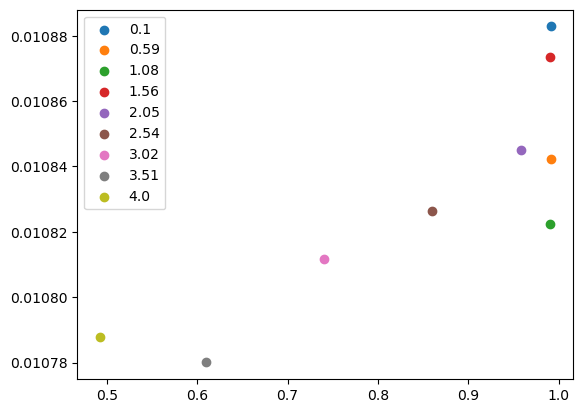

In [52]:
handle = open("series_resistances.pkl", 'rb')
data = pickle.load(handle)
handle.close()
print(data.keys(),data)

for volt in data.keys():
    # print("mean voltage ch1",volt,np.mean(data[volt][0][0]))
    # print("mean voltage ch2",volt,np.mean(data[volt][0][1]))
    print("ratio",np.mean(data[volt][0][1])/np.mean(data[volt][0][0]))
    
    plt.scatter(np.mean(data[volt][0][0]),
                np.mean(data[volt][0][1]),
                label=volt
                )
plt.legend(loc="upper left")


(0.0, 0.01)

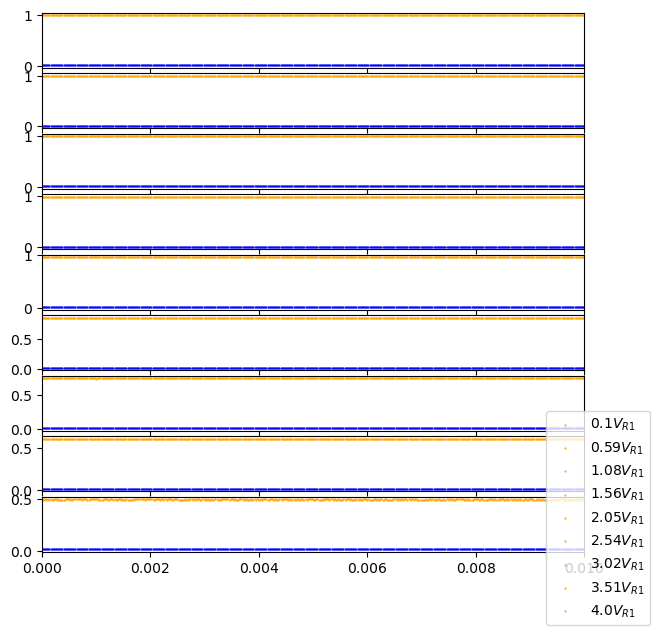

In [42]:
# For quickly checking the measured data. 

with open("series_resistances.pkl","rb") as handle:
    data = pickle.load(handle)

n_volt = data.keys()

fig, axes = plt.subplots(len(n_volt),1,figsize=(7,7),sharex=True)
fig.subplots_adjust(hspace=0.1)

for i,volt in enumerate(n_volt):
    # We only look at the first attempt at each volt. 
    v0 = data[volt][0][0]
    v1 = data[volt][0][1]
    axes[i].scatter(t,v0,color="orange",s=0.3,label=str(volt)+"$V_{R1}$")
    axes[i].scatter(t,v1,color="blue",s=0.3)#,label=str(volt)+"$V_{R2}$")
fig.legend(loc="lower right")
axes[0].set_xlim(0.0,0.01)
